# Answer the questions from the introduction

## i. What is leave-one-out? Provide limitations and strengths.   

Leave-One-Out Cross-Validation (LOOCV) is a resampling technique where each abservation is used once as test set while the remaining data forms the training set. This is repeated for all data points   
1. Strengths:   
    Uses neatrly all data for training, reducing bias   
    Works well for small datasets   
    Deterministic (no randomness in splits)   
2. Limitations:   
    Computationally expensive   
    Hight variance in perfomance estimation due to similarity between training sets   
    Not suitable for large datasets

## ii. How do Grid Search, Randomized Grid Search, and Bayesian optimization work?
   
<b>Grid Search:</b>   
    Evaluates all possible hyperparameter combinations from a predefined grid   
    Exhaustive but computationally expensive   
    
<b>Randomized Grid Search:</b>   
    Randomly samples hyperparameters from a distribution or predefined list   
    Faster than Grid Search and often finds near-optimal solutions   
   
<b>Bayesian Optimization:</b>   
    Uses probabilistic models (e.g., Gaussian Processes) to predict promising hyperparameters   
    Focuses on regions likely to improve performance, balancing exploration and exploitation   
    More efficient than Grid/Randomized Search for expensive evaluations   

## iii. Explain classification of feature selection methods. Explain how Pearson and Chi2 work. Explain how Lasso works. Explain what permutation significance is. Become familiar with SHAP.

<b>Feature selection methods can be categorized as:</b>   
   
1. Filter Methods:   
Select features based on statistical measures (e.g., Pearson correlation, Chi²)   
Independent of the model (fast but less accurate)   
   
2. Wrapper Methods:   
Use a model to evaluate feature subsets (e.g., Recursive Feature Elimination)   
Computationally expensive but more accurate   
   
3. Embedded Methods:   
Feature selection is part of the model training (e.g., Lasso, Decision Trees)   
   
<b>How Pearson and Chi² Work</b>   

1. Pearson Correlation:   
Measures linear dependence between a feature and the target (continuous data)   
High absolute value → stronger relationship   

2. Chi-Square (χ²):   
Tests independence between categorical features and target   
Higher χ² score → stronger dependence   
   
<b>How Lasso Works</b>   
   
1. Lasso (L1 regularization) adds a penalty term to the loss function: Loss=MSE+λ∑∣wi∣   
2. Shrinks some coefficients to zero, effectively performing feature selection   
   
<b>Permutation Feature Importance</b>   
   
1. Measures importance by shuffling a feature and observing the drop in model performance   
2. If shuffling degrades performance significantly, the feature is important   

<b>SHAP (SHapley Additive exPlanations)</b>   
   
1. A game-theoretic approach to explain model predictions by assigning importance values to features   
2. Computes the contribution of each feature to the prediction relative to all possible feature combinations   
3. Provides both global and local interpretability   

# Introduction — do all the preprocessing from the previous lesson

## Imports

In [1]:
import shap
import time
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV, ElasticNet
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score

## Preprocessing

In [2]:
def clean_features(features):
    cleaned_features = []
    for f in features:
        cleaned_f = str(f).replace("'", "").replace('"', '').replace('[', '').replace(']', '').strip()
        cleaned_features.append(cleaned_f)
    return cleaned_features

In [3]:
raw_train_data = pd.read_json('data/train.json')
data_trains = raw_train_data[['bathrooms', 'bedrooms', 'interest_level', 'manager_id', 'created',  'features', 'price']]
data_train = data_trains.copy()

lower_bound = data_train['price'].quantile(0.01)
upper_bound = data_train['price'].quantile(0.99)
data_train = data_train[(data_train['price'] >= lower_bound) & (data_train['price'] <= upper_bound)]

data_train['features'] = data_train['features'].apply(clean_features)

all_features = []
for index, row in data_train.iterrows():
    features = row['features']
    all_features.extend(features)

counter = Counter(all_features)
top_20_features = counter.most_common(20)

for feature_name, _ in top_20_features:
    data_train[feature_name] = data_train['features'].apply(lambda x: int(feature_name in x))

data_train.drop(columns=['features'], inplace=True)
data_train.reset_index(drop=True, inplace=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48379 entries, 0 to 48378
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bathrooms            48379 non-null  float64
 1   bedrooms             48379 non-null  int64  
 2   interest_level       48379 non-null  object 
 3   manager_id           48379 non-null  object 
 4   created              48379 non-null  object 
 5   price                48379 non-null  int64  
 6   Elevator             48379 non-null  int64  
 7   Hardwood Floors      48379 non-null  int64  
 8   Cats Allowed         48379 non-null  int64  
 9   Dogs Allowed         48379 non-null  int64  
 10  Doorman              48379 non-null  int64  
 11  Dishwasher           48379 non-null  int64  
 12  No Fee               48379 non-null  int64  
 13  Laundry in Building  48379 non-null  int64  
 14  Fitness Center       48379 non-null  int64  
 15  Pre-War              48379 non-null 

In [4]:
raw_test_data = pd.read_json('data/test.json')
data_tests = raw_test_data[['bathrooms', 'bedrooms', 'manager_id', 'created', 'features', 'price']]
data_test = data_tests.copy()

lower_bound = data_test['price'].quantile(0.01)
upper_bound = data_test['price'].quantile(0.99)
data_test = data_test[(data_test['price'] >= lower_bound) & (data_test['price'] <= upper_bound)]

data_test['features'] = data_test['features'].apply(clean_features)

for feature_name, _ in top_20_features:
    data_test[feature_name] = data_test['features'].apply(lambda x: int(feature_name in x))

data_test.drop(columns=['features'], inplace=True)
data_test.reset_index(drop=True, inplace=True)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73216 entries, 0 to 73215
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bathrooms            73216 non-null  float64
 1   bedrooms             73216 non-null  int64  
 2   manager_id           73216 non-null  object 
 3   created              73216 non-null  object 
 4   price                73216 non-null  int64  
 5   Elevator             73216 non-null  int64  
 6   Hardwood Floors      73216 non-null  int64  
 7   Cats Allowed         73216 non-null  int64  
 8   Dogs Allowed         73216 non-null  int64  
 9   Doorman              73216 non-null  int64  
 10  Dishwasher           73216 non-null  int64  
 11  No Fee               73216 non-null  int64  
 12  Laundry in Building  73216 non-null  int64  
 13  Fitness Center       73216 non-null  int64  
 14  Pre-War              73216 non-null  int64  
 15  Laundry in Unit      73216 non-null 

# Implement the next methods

## Split data into 2 parts randomly with parameter test_size (ratio from 0 to 1), return training and test samples

In [5]:
def train_test_data(X, y, test_size=0.2, random_state=None, shuffle=True):
    """
    Divides the data into training and test samples randomly.
    
    Parameters:
    X - attributes (array, list, or DataFrame)
    y is the target variable (array, list, or Series)
    text_size - for the test sample (default is 0.2)
    random_state - seed for the random number generator (default None)
    
    Returns:
    X_train, X_test, y_train, y_test - split selections
    """
    if random_state is not None:
        np.random.seed(random_state)

    if not 0 < test_size < 1:
        raise ValueError("test_size must be between 0 and 1")
    
    indices = np.arange(len(X))
    if shuffle == True:
        np.random.shuffle(indices)

    split_idx = int(len(X) * (1 - test_size))

    train_idx, test_idx = indices[:split_idx], indices[split_idx:]

    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    else:
        X_train = [X[i] for i in train_idx]
        X_test = [X[i] for i in test_idx]
        y_train = [y[i] for i in train_idx]
        y_test = [y[i] for i in test_idx]


    return X_train, X_test, y_train, y_test

## Randomly split data into 3 parts with parameters validation_size and test_size, return train, validation and test samples

In [6]:
def train_val_test_data(X, y, val_size=0.2, test_size=0.2, random_state=None, shuffle=True):
    """
    Divides the data into training and test samples randomly.
    
    Parameters:
    X - attributes (array, list, or DataFrame)
    y is the target variable (array, list, or Series)
    text_size - for the test sample (default is 0.2)
    random_state - seed for the random number generator (default None)
    
    Returns:
    X_train, X_test, y_train, y_test - split selections
    """
    X_train_val, X_test, y_train_val, y_test = train_test_data(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        shuffle=shuffle
    )

    relative_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_data(
        X_train_val, y_train_val,
        test_size=relative_val_size,
        random_state=random_state,
        shuffle=shuffle
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

## Split data into 2 parts with parameter date_split, return train and test samples split by date_split param

In [7]:
def train_test_by_date(X, y, date_series, date_split):
    """
    Divides the attributes (X) and the target variable (y) into train and test by the specified date.
    
    Parameters:
    ----------
    X : pandas.DataFrame or numpy.array
        The feature matrix
    y : pandas.Series or numpy.array
        Vector of the target variable
    date_series : pandas.Series
        A series with dates for separation (must match X and y)
    date_split : str or datetime-like
        Date for separation (inclusive in train)
    
    Returns:
    -----------
    X_train, X_test : separated features
    y_train, y_test : separated target variables
    """
    if not isinstance(date_split, pd.Timestamp):
        date_split = pd.to_datetime(date_split)

    train_mask = date_series <= date_split

    if isinstance(X, pd.DataFrame):
        X_train, X_test = X[train_mask], X[~train_mask]
    else:
        X_train, X_test = X[train_mask], X[~train_mask]
    
    if isinstance(y, pd.Series):
        y_train, y_test = y[train_mask], y[~train_mask]
    else:
        y_train, y_test = y[train_mask], y[~train_mask]
    
    return X_train, X_test, y_train, y_test

## Split data into 3 parts with parameters validation_date and test_date, return train, validation and test samples split by input params

In [8]:
def train_val_test_by_date(X, y, validation_date, test_date, date_column='date'):
    """
    Divides the features and the target variable into training, validation, and test samples by date.
    
    Parameters:
    ----------
    X : pandas.DataFrame
        A dataframe with the attributes (must contain a date column)
    y : pandas.Series or numpy.array
        Target variable
    validation_date : str or datetime
        Start date of the validation sample
    test_date : str or datetime
        Start date of the test sample
    date_column : str, optional
        The name of the column with the date in X (default is 'date')
    
    Returns:
    -----------
    X_train, X_val, X_test : pandas.DataFrame
        Attributes for training, validation, and test samples
    y_train, y_val, y_test : pandas.Series or numpy.array
        Target variable for training, validation, and test samples
    """
    if not np.array_equal(X.index, y.index):
        raise ValueError("X and y indexes do not match")
    
    if not isinstance(validation_date, pd.Timestamp):
        validation_date = pd.to_datetime(validation_date)
    if not isinstance(test_date, pd.Timestamp):
        test_date = pd.to_datetime(test_date)

    if validation_date > test_date:
        raise ValueError("validation_date must be earlier than test_date")
    
    if isinstance(X, pd.DataFrame):
        date_series = X[date_column]
    else:
        raise ValueError("X should be a pandas.DataFrame with a date column")
    
    X_train_val, X_test, y_train_val, y_test = train_test_by_date(
        X, y, date_series, test_date
    )
    
    X_train, X_val, y_train, y_val = train_test_by_date(
        X_train_val, y_train_val, date_series[date_series < test_date], validation_date
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Implement the next cross-validation methods

## K-Fold, where k is the input parameter, returns a list of train and test indices

In [9]:
def my_k_fold(data, k, random_state=None):
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(data))
    rng.shuffle(indices)

    fold_sizes = np.full(k, len(indices) // k)
    fold_sizes[:len(indices) % k] += 1
    current = 0
    splits = []

    for fold_size in fold_sizes:
        test_idx = indices[current:current + fold_size]
        train_idx = np.concatenate([indices[:current], indices[current + fold_size:]])
        splits.append((train_idx.tolist(), test_idx.tolist()))
        current += fold_size

    return splits

## Grouped K-Fold, where k and group_field are input parameters, returns list of train and test indices

In [10]:
def my_grouped_k_fold(data, k, group_field, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = data[group_field].unique()
    rng.shuffle(groups)

    fold_sizes = np.full(k, len(groups) // k)
    fold_sizes[:len(groups) % k] += 1
    current = 0
    splits = []

    for fold_size in fold_sizes:
        test_groups = groups[current:current + fold_size]
        test_idx = data[data[group_field].isin(test_groups)].index
        train_idx = data[~data[group_field].isin(test_groups)].index
        splits.append((train_idx.tolist(), test_idx.tolist()))
        current += fold_size

    return splits

## Stratified K-fold, where k and stratify_field are input parameters, returns list of train and test indices

In [11]:
def my_stratified_k_fold(data, k, stratify_field, random_state=None):
    rng = np.random.default_rng(random_state)
    splits = []
    stratify_values = data[stratify_field]
    unique_classes = stratify_values.unique()

    class_indices = {cls: stratify_values[stratify_values == cls].index.tolist()
                     for cls in unique_classes}

    folds = [[] for _ in range(k)]

    for cls, idx_list in class_indices.items():
        rng.shuffle(idx_list)
        cls_fold_sizes = np.full(k, len(idx_list) // k)
        cls_fold_sizes[:len(idx_list) % k] += 1
        current = 0
        for i, fold_size in enumerate(cls_fold_sizes):
            folds[i].extend(idx_list[current:current + fold_size])
            current += fold_size

    for i in range(k):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(k) if j != i for idx in folds[j]])
        splits.append((train_idx.tolist(), test_idx.tolist()))

    return splits

## Time series split, where k and date_field are input parameters, returns list of train and test indices

In [12]:
def my_time_series(data, k, date_field):
    data_sorted = data.sort_values(by=date_field)
    indices = data_sorted.index.to_numpy()
    fold_size = len(data_sorted) // (k + 1)
    splits = []

    for i in range(1, k + 1):
        test_start = i * fold_size
        test_end = test_start + fold_size
        test_idx = indices[test_start:test_end]
        train_idx = indices[:test_start]
        splits.append((train_idx.tolist(), test_idx.tolist()))

    return splits

# Cross-validation comparison

In [13]:
X_train = data_train.drop('price', axis=1)

In [14]:
manual_kfold = my_k_fold(X_train, 5, random_state=42)
manual_grouped = my_grouped_k_fold(X_train, 5, group_field='manager_id', random_state=42)
manual_stratified = my_stratified_k_fold(X_train, 5, stratify_field='interest_level', random_state=42)
manual_time_series = my_time_series(X_train, 5, date_field='created')

In [15]:
sklearn_kfold = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X_train))
sklearn_grouped = list(GroupKFold(n_splits=5).split(X_train, groups=X_train['manager_id']))
sklearn_stratified = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, X_train['interest_level']))
sklearn_time_series = list(TimeSeriesSplit(n_splits=5).split(X_train.sort_values('created')))

In [16]:
def auto_compare_distributions(method_name, df, idx_train, idx_test, columns, ncols=3, figsize=(36, 20)):
    n = len(columns)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize[0], nrows * (figsize[1] / ncols)))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        if column not in df.columns:
            ax.set_visible(False)
            continue

        train_vals = df.iloc[idx_train][column]
        test_vals = df.iloc[idx_test][column]

        # Binary
        unique_vals = df[column].dropna().unique()
        if pd.api.types.is_numeric_dtype(df[column]) and set(unique_vals).issubset({0, 1}):
            means = [train_vals.mean(), test_vals.mean()]
            sns.barplot(x=['Train', 'Test'], y=means, ax=ax)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Mean value')
            ax.set_title(f"{column} (binary)")

        # Numeric continuous
        elif pd.api.types.is_numeric_dtype(df[column]):
            sns.kdeplot(train_vals.dropna(), label='Train', fill=True, ax=ax)
            sns.kdeplot(test_vals.dropna(), label='Test', fill=True, ax=ax)
            ax.set_title(f"{column} (continuous)")

        # Categorical
        else:
            train_counts = train_vals.value_counts(normalize=True)
            test_counts = test_vals.value_counts(normalize=True)
            all_categories = sorted(set(train_counts.index).union(set(test_counts.index)))

            train_freq = [train_counts.get(cat, 0) for cat in all_categories]
            test_freq = [test_counts.get(cat, 0) for cat in all_categories]
            x = np.arange(len(all_categories))
            width = 0.35

            ax.bar(x - width/2, train_freq, width, label='Train')
            ax.bar(x + width/2, test_freq, width, label='Test')
            ax.set_xticks(x)
            ax.set_xticklabels(all_categories, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel('Freq')
            ax.set_title(f"{column} (categorical)")

        ax.grid(True)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"Feature distributions — {method_name}", fontsize=16)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [17]:
k_fold_cols = ['bathrooms', 'bedrooms', 'interest_level']
g_k_fold_cols = k_fold_cols + ['manager_id']
strat_k_fold_cols = k_fold_cols
time_ser_split_cols = k_fold_cols + ['created']

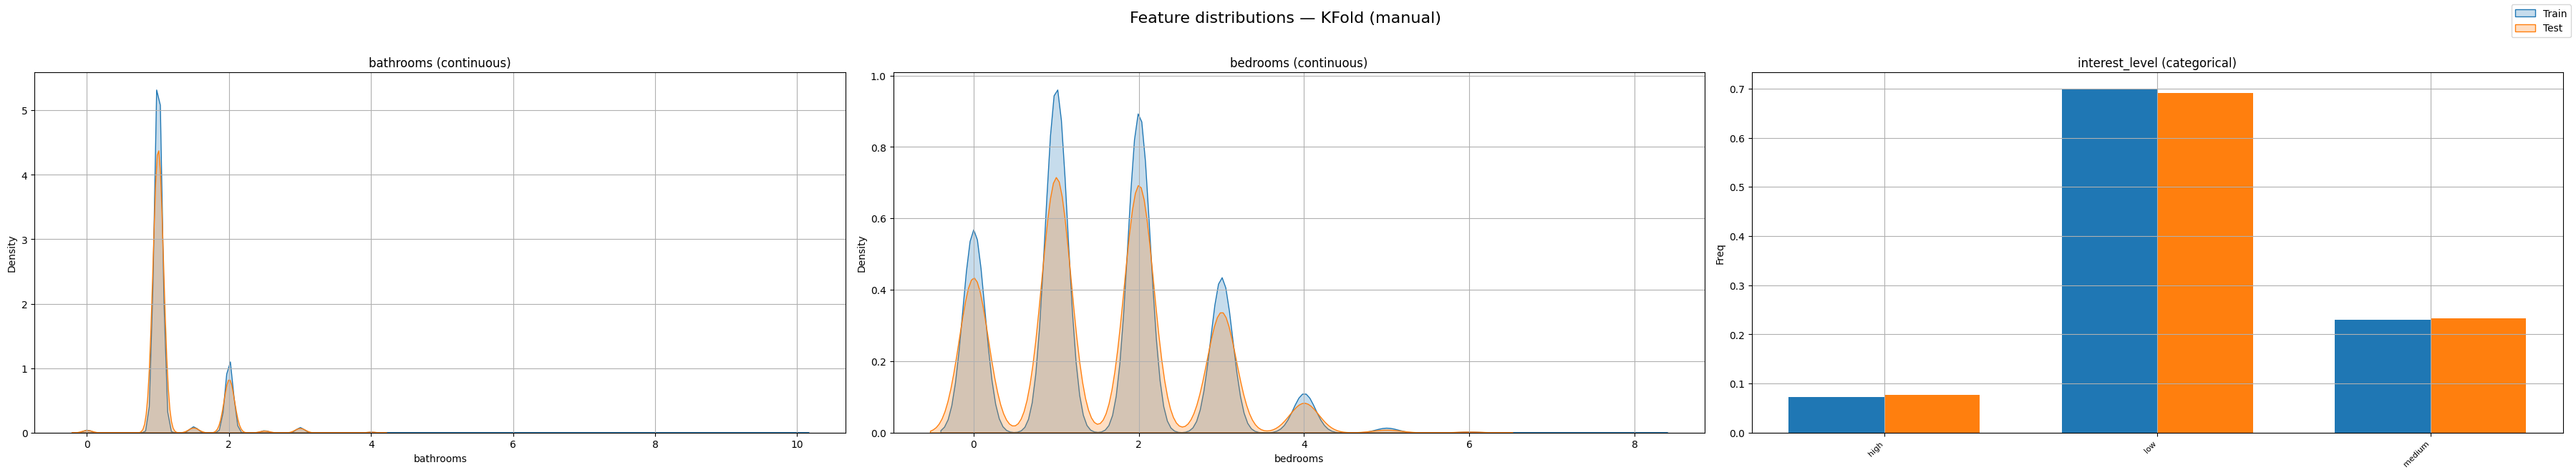

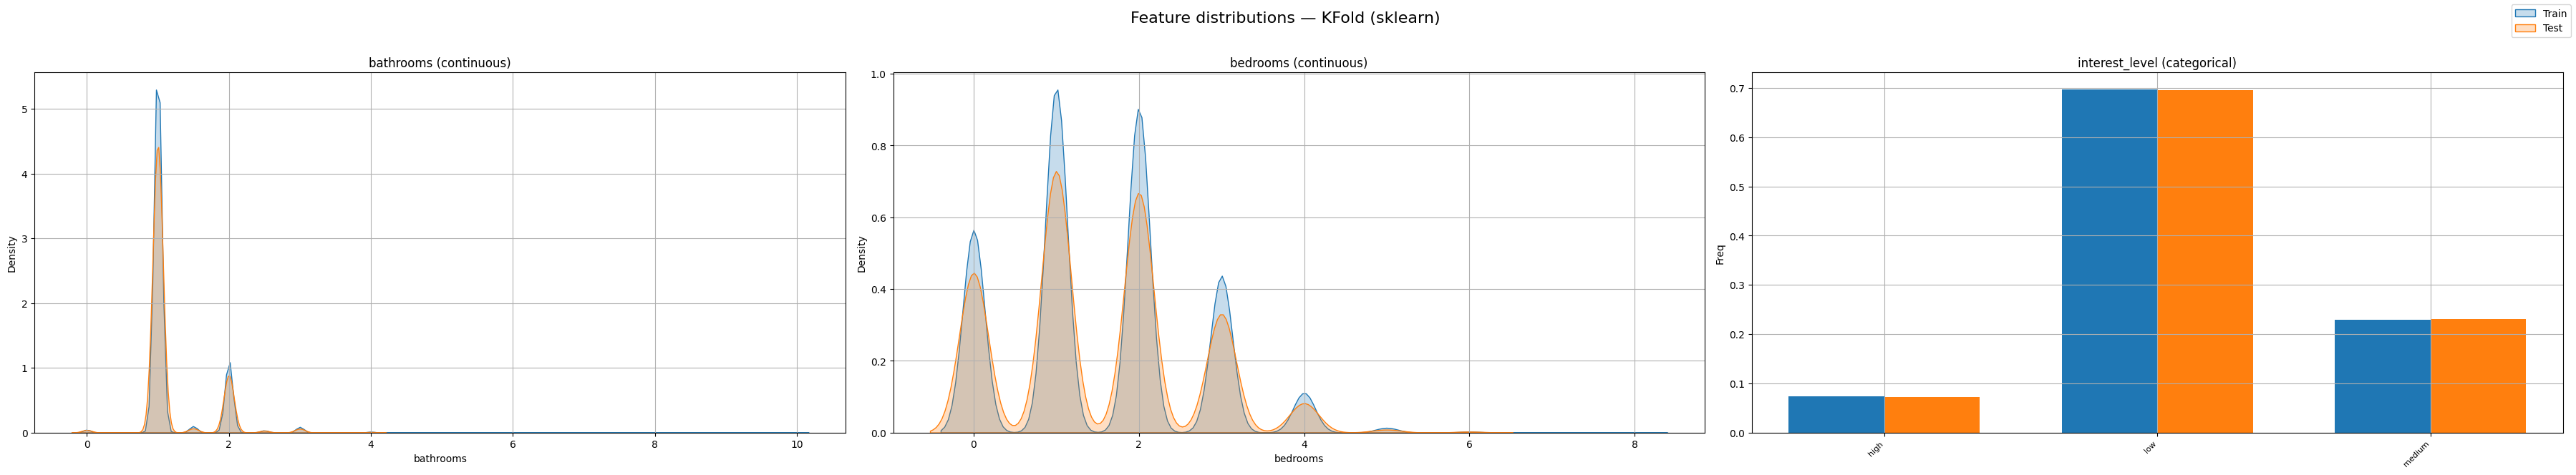

In [18]:
auto_compare_distributions("KFold (manual)", X_train, *manual_kfold[0], columns=k_fold_cols)
auto_compare_distributions("KFold (sklearn)", X_train, *sklearn_kfold[0], columns=k_fold_cols)

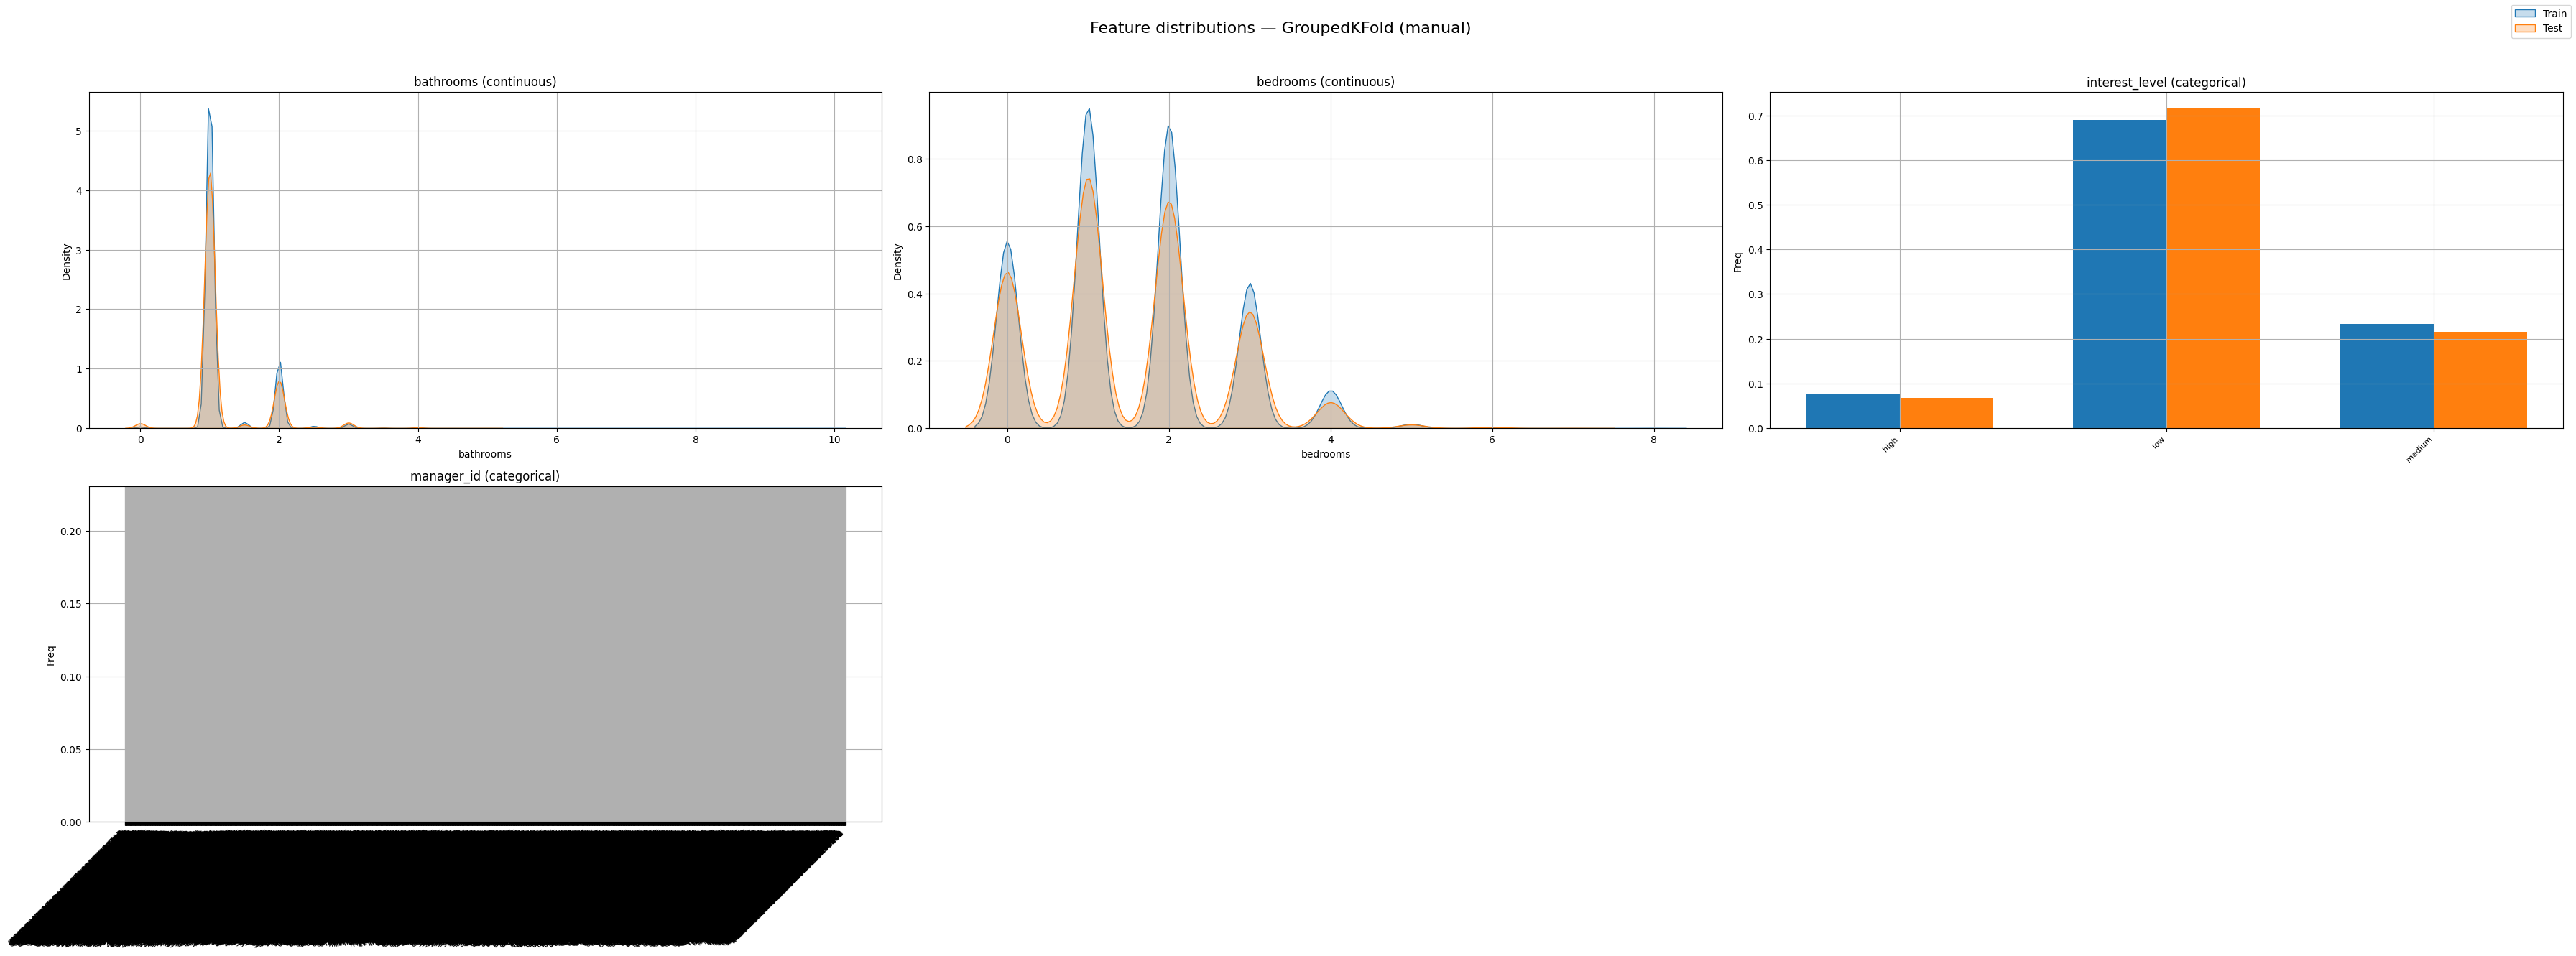

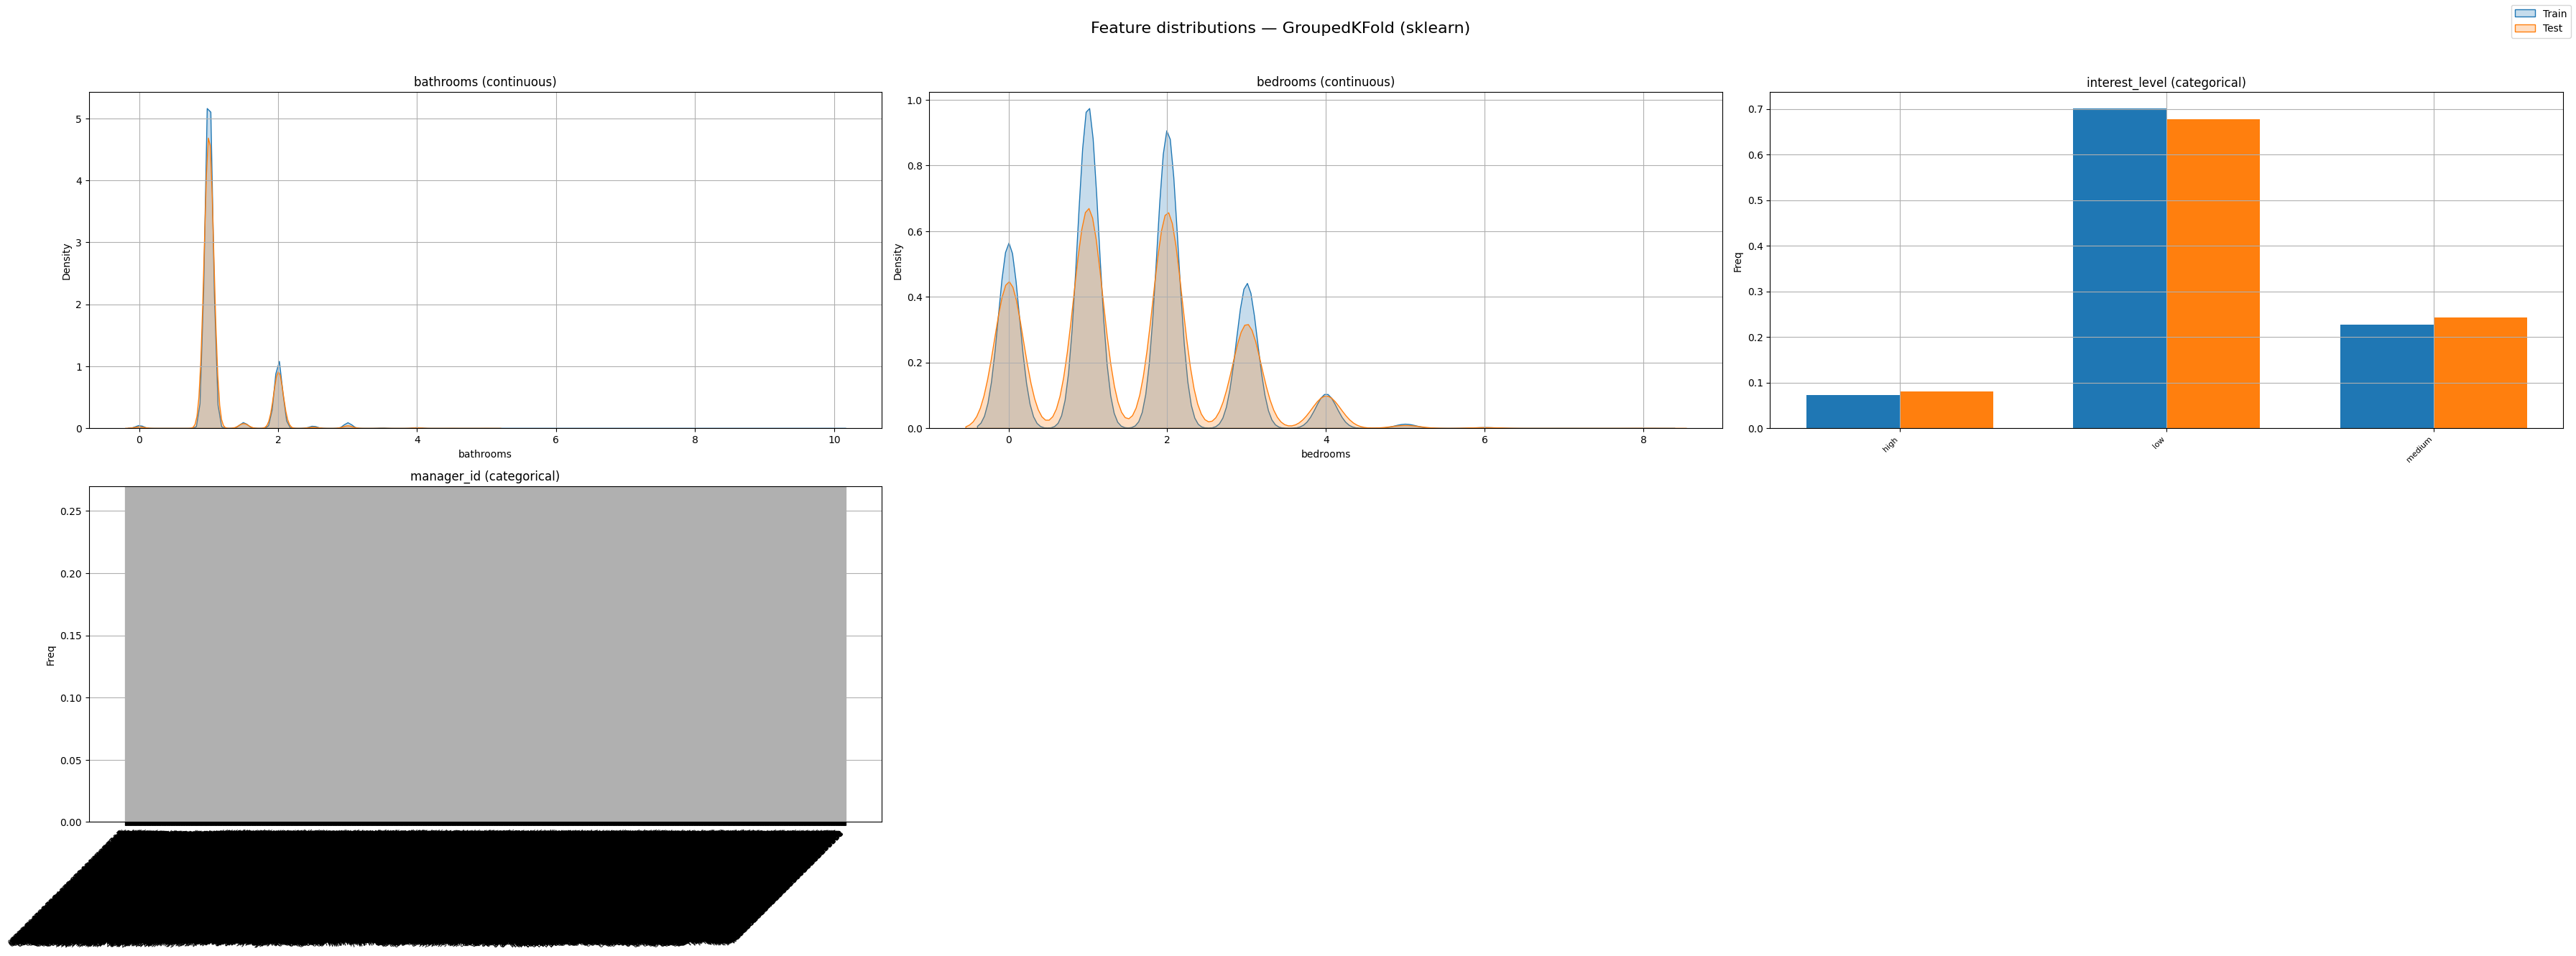

In [19]:
auto_compare_distributions("GroupedKFold (manual)", X_train, *manual_grouped[0], columns=g_k_fold_cols)
auto_compare_distributions("GroupedKFold (sklearn)", X_train, *sklearn_grouped[0], columns=g_k_fold_cols)

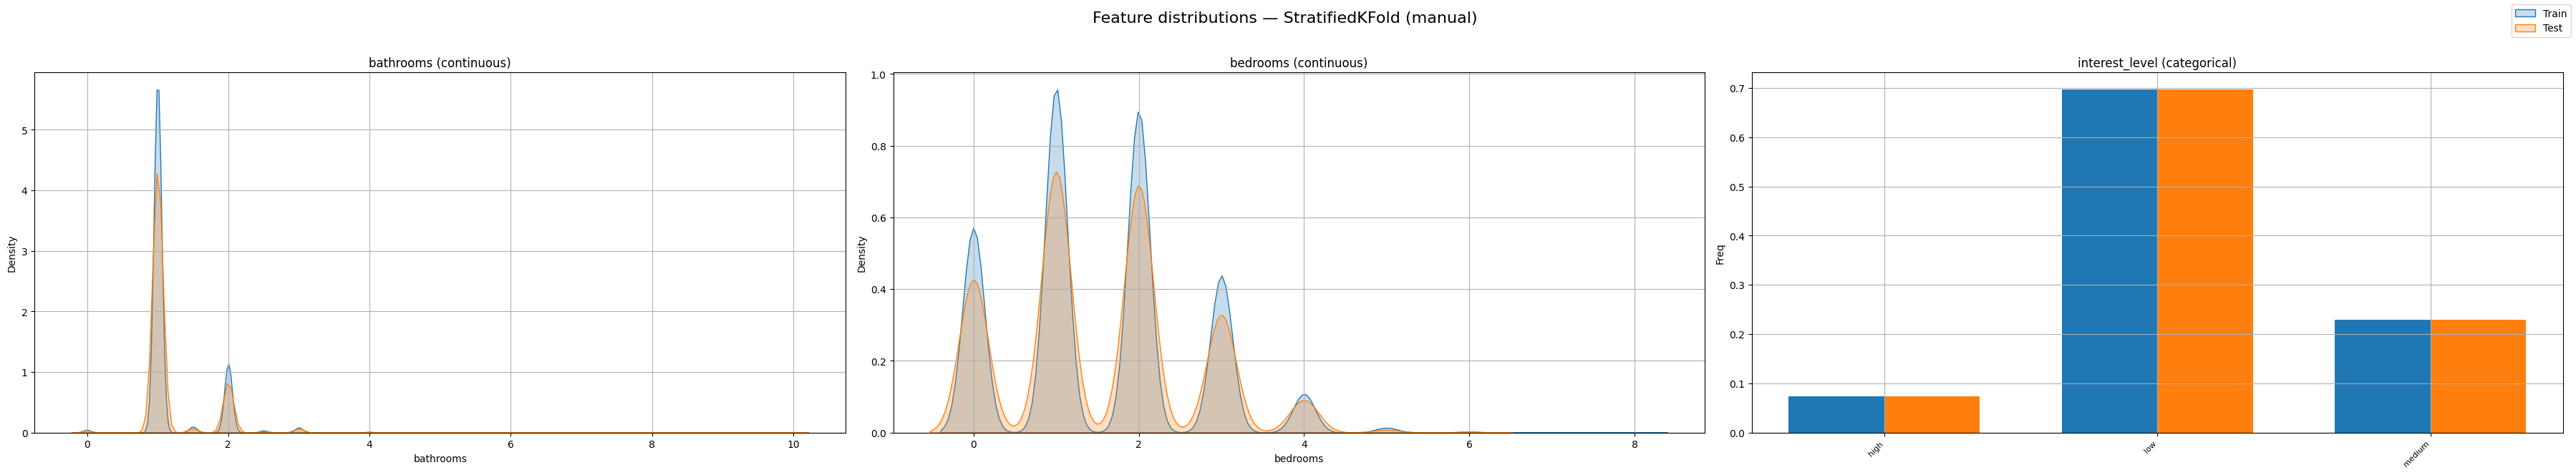

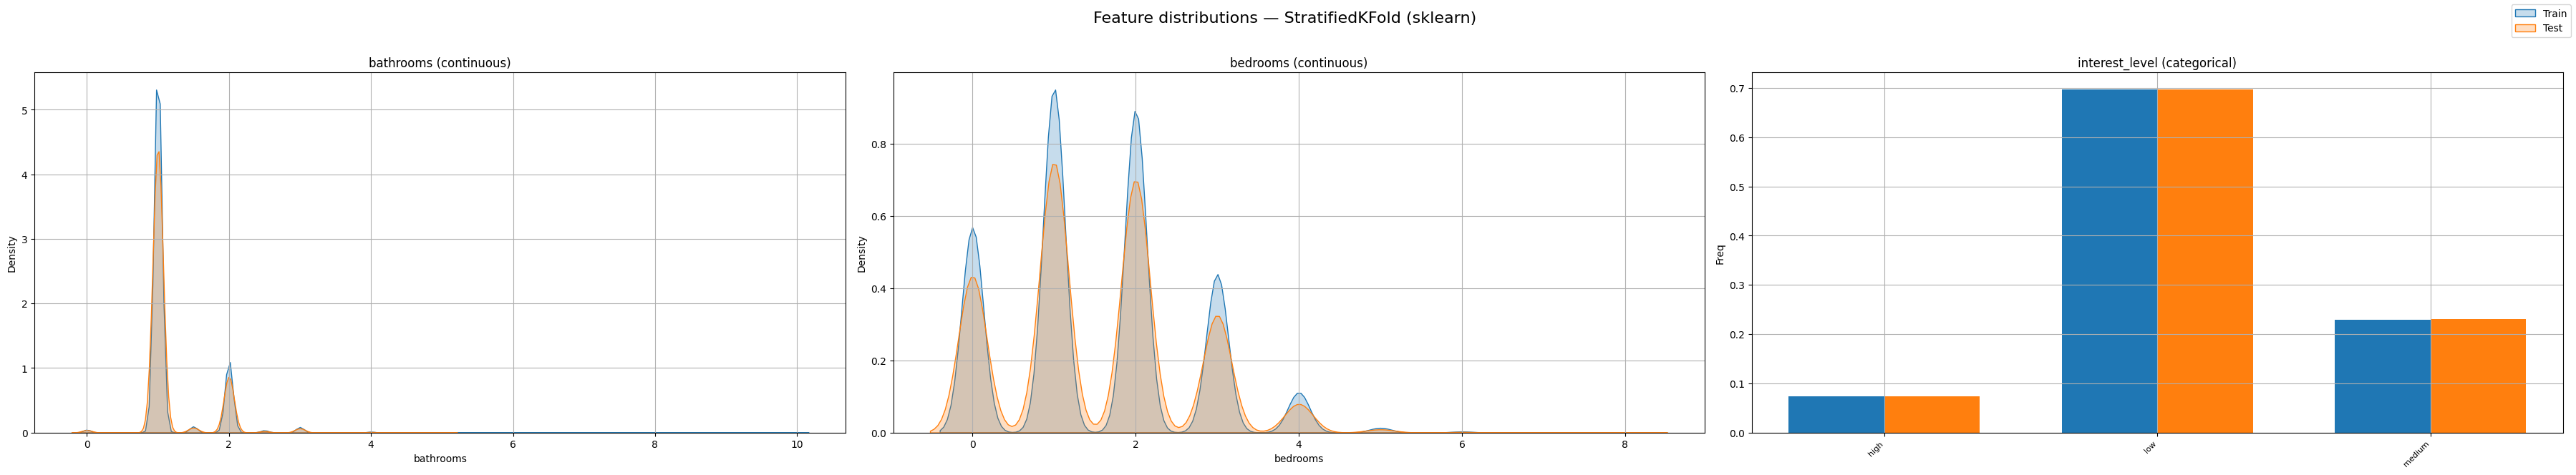

In [20]:
auto_compare_distributions("StratifiedKFold (manual)", X_train, *manual_stratified[0], columns=strat_k_fold_cols)
auto_compare_distributions("StratifiedKFold (sklearn)", X_train, *sklearn_stratified[0], columns=strat_k_fold_cols)

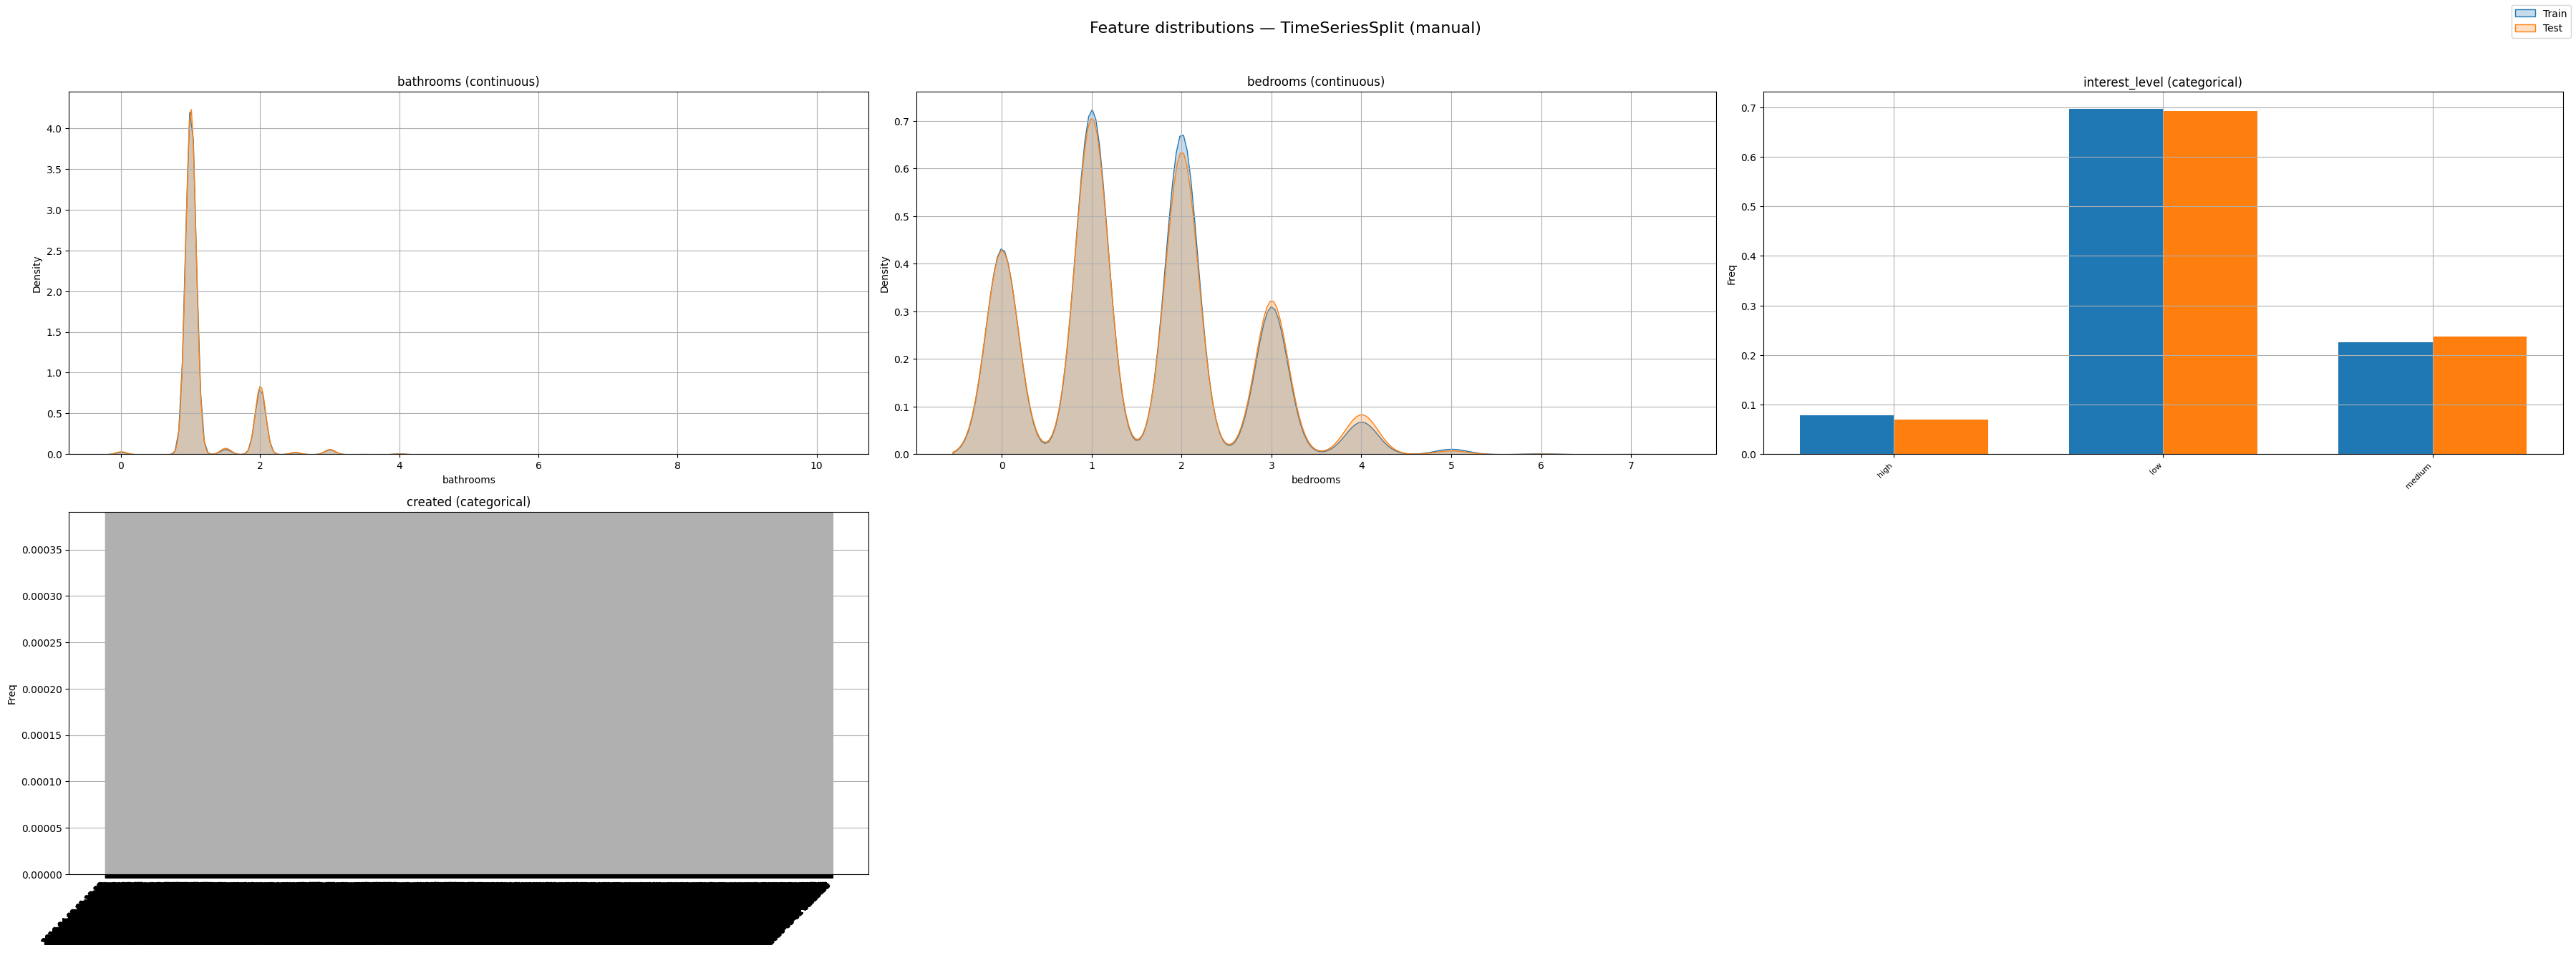

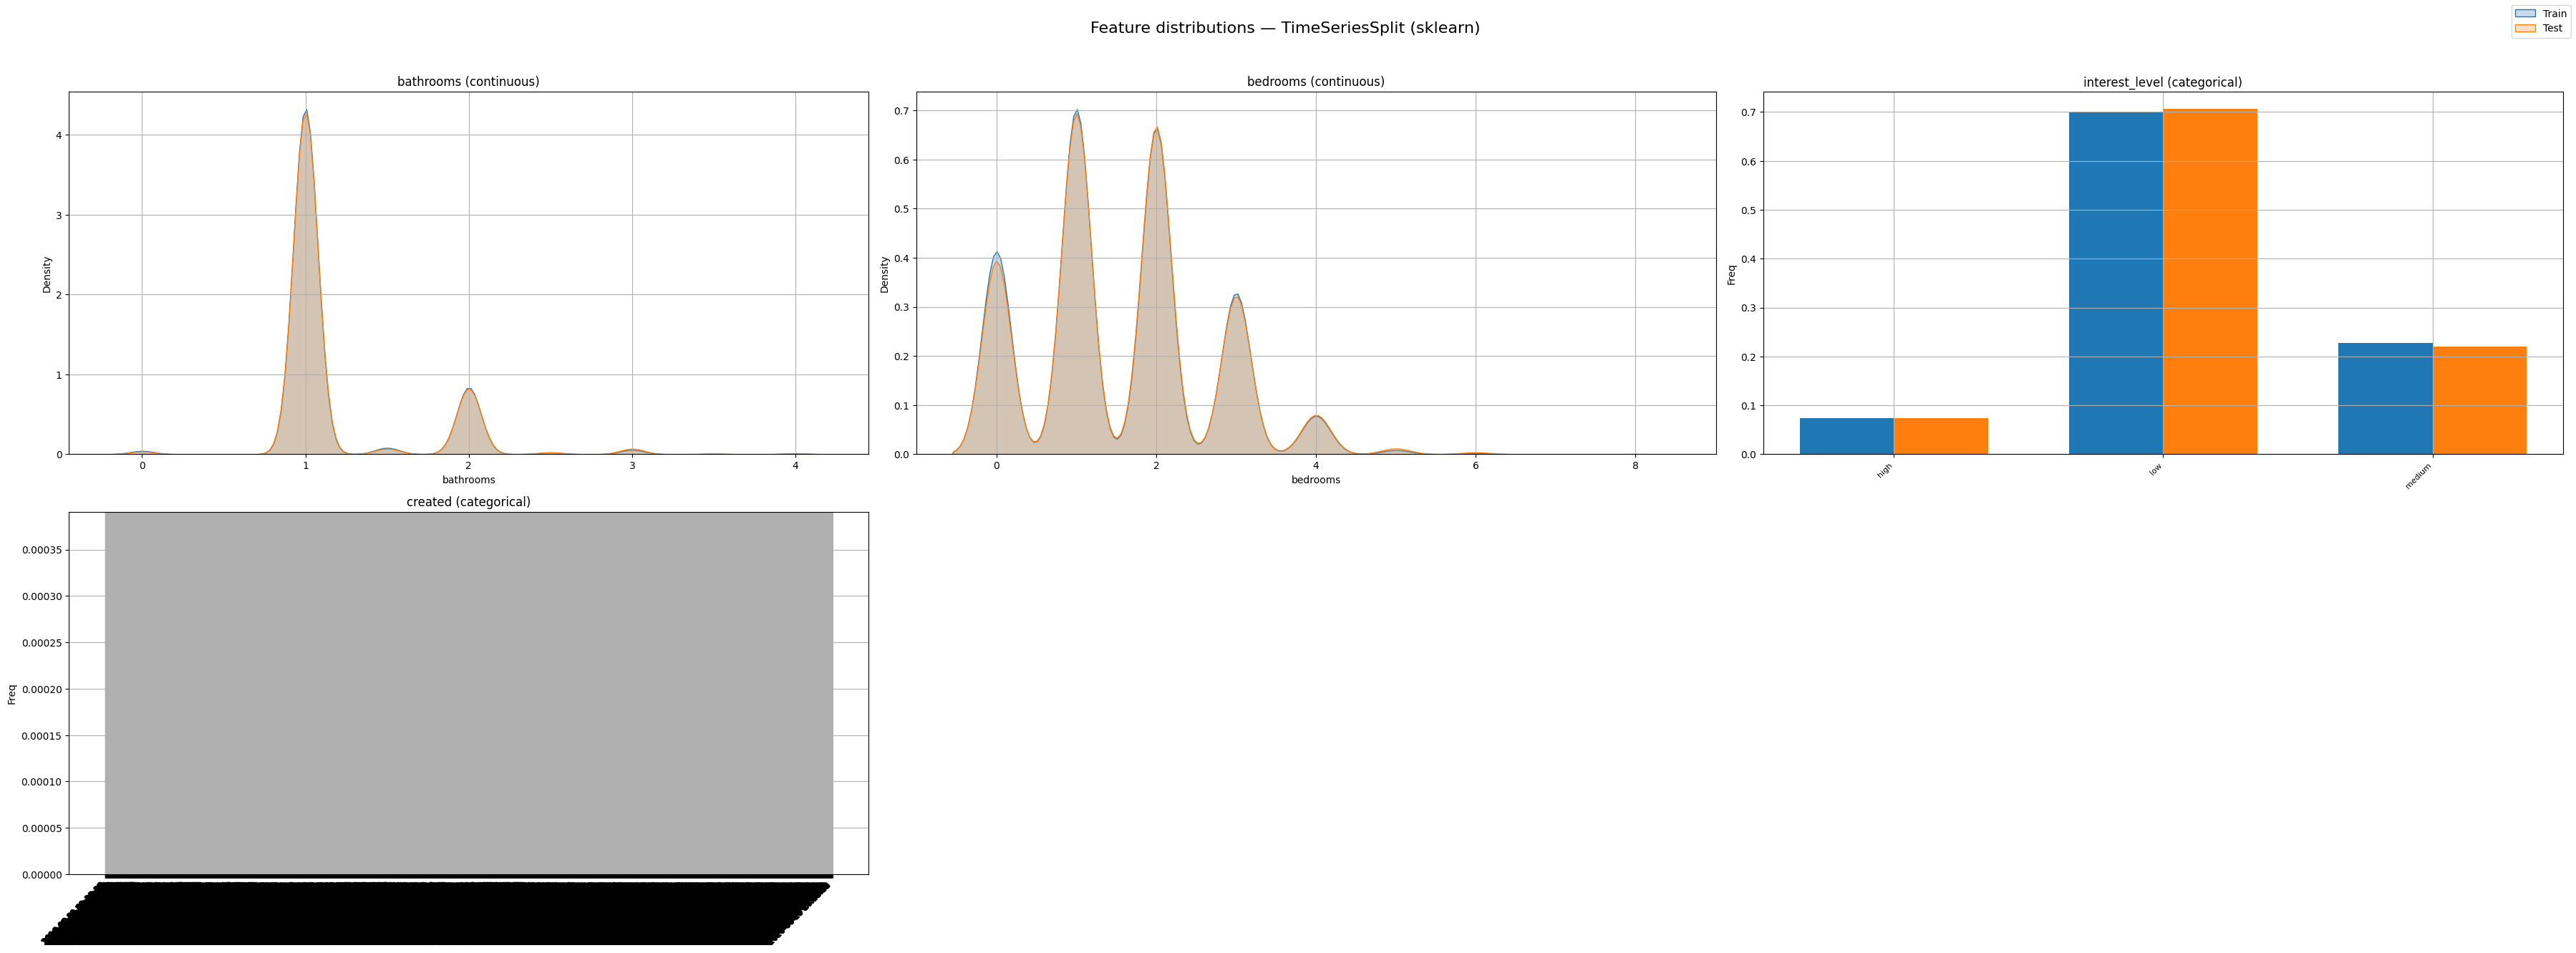

In [21]:
auto_compare_distributions("TimeSeriesSplit (manual)", X_train, *manual_time_series[0], columns=time_ser_split_cols)
auto_compare_distributions("TimeSeriesSplit (sklearn)", X_train, *sklearn_time_series[0], columns=time_ser_split_cols)

## Stratified K-fold is the best

# Feature Selection

## Fit a Lasso regression model with normalized features. Use your method for splitting samples into 3 parts by field created with 60/20/20 ratio — train/validation/test

In [22]:
results = []

In [23]:
data_train = data_train.drop(['manager_id', 'created', 'interest_level'], axis=1)

In [24]:
X = data_train.drop(['price'], axis=1)
y = data_train['price']

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_data(X, y, 0.2, 0.2, random_state=42)

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [27]:
start = time.time()
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

val_pred = lasso.predict(X_val_scaled)
test_pred = lasso.predict(X_test_scaled)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
time_full = time.time() - start

results.append(['Baseline (full features)', val_rmse, test_rmse, time_full])
print(f"[FULL MODEL] Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Time: {time_full:.2f} sec")

[FULL MODEL] Val RMSE: 1033.5363, Test RMSE: 1020.2746, Time: 0.12 sec


## Sort features by weight coefficients from model, fit model to top 10 features and compare quality

In [28]:
coefs = pd.Series(lasso.coef_, index=X_train.columns)
top10_weights = coefs.abs().sort_values(ascending=False).head(10).index.tolist()

X_train_top = X_train[top10_weights]
X_val_top = X_val[top10_weights]
X_test_top = X_test[top10_weights]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_val_scaled = scaler.transform(X_val_top)
X_test_scaled = scaler.transform(X_test_top)

start = time.time()
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

val_pred = lasso.predict(X_val_scaled)
test_pred = lasso.predict(X_test_scaled)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
time_weights = time.time() - start

results.append(['Lasso coef (top-10)', val_rmse, test_rmse, time_weights])
print(f"[WEIGHTS] Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Time: {time_weights:.2f} sec")

[WEIGHTS] Val RMSE: 1039.2887, Test RMSE: 1024.9987, Time: 0.06 sec


## Implement method for simple feature selection by nan-ratio in feature and correlation. Apply this method to feature set and take top 10 features, refit model and measure quality

In [29]:
nan_ratio = X_train.isna().mean()
corr = data_train.corr()['price'].abs().drop('price')

score = (1 - nan_ratio) * corr
top10_nan_corr = score.sort_values(ascending=False).head(10).index.tolist()

X_train_top = X_train[top10_nan_corr]
X_val_top = X_val[top10_nan_corr]
X_test_top = X_test[top10_nan_corr]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_val_scaled = scaler.transform(X_val_top)
X_test_scaled = scaler.transform(X_test_top)

start = time.time()
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

val_pred = lasso.predict(X_val_scaled)
test_pred = lasso.predict(X_test_scaled)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
time_nan_corr = time.time() - start

results.append(['NaN+Correlation (top-10)', val_rmse, test_rmse, time_nan_corr])
print(f"[NaN+CORR] Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Time: {time_nan_corr:.2f} sec")

[NaN+CORR] Val RMSE: 1044.9171, Test RMSE: 1031.8202, Time: 0.06 sec


## Implement permutation importance method and take top 10 features, refit model and measure quality

In [30]:
scaler_full = MinMaxScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train)
X_val_full_scaled = scaler_full.transform(X_val)
X_test_full_scaled = scaler_full.transform(X_test)

lasso_full = LassoCV(cv=5)
lasso_full.fit(X_train_full_scaled, y_train)

result = permutation_importance(lasso_full, X_val_full_scaled, y_val, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X_val.columns)
top10_perm = importances.sort_values(ascending=False).head(10).index.tolist()

X_train_top = X_train[top10_perm]
X_val_top = X_val[top10_perm]
X_test_top = X_test[top10_perm]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_val_scaled = scaler.transform(X_val_top)
X_test_scaled = scaler.transform(X_test_top)

start = time.time()
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

val_pred = lasso.predict(X_val_scaled)
test_pred = lasso.predict(X_test_scaled)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
time_perm = time.time() - start

results.append(['Permutation (top-10)', val_rmse, test_rmse, time_perm])
print(f"[PERMUTATION] Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Time: {time_perm:.2f} sec")

[PERMUTATION] Val RMSE: 1039.3310, Test RMSE: 1026.3990, Time: 0.06 sec


## Import Shap and also refit model on top 10 features

In [31]:
explainer = shap.Explainer(lasso, X_val_scaled)
shap_values = explainer(X_val_scaled)

mean_abs = np.abs(shap_values.values).mean(axis=0)
top_features = X_val_top.columns
top10_shap = pd.Series(mean_abs, index=top_features).sort_values(ascending=False).head(10).index.tolist()

X_train_top = X_train[top10_shap]
X_val_top = X_val[top10_shap]
X_test_top = X_test[top10_shap]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_val_scaled = scaler.transform(X_val_top)
X_test_scaled = scaler.transform(X_test_top)

start = time.time()
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

val_pred = lasso.predict(X_val_scaled)
test_pred = lasso.predict(X_test_scaled)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
time_shap = time.time() - start

results.append(['SHAP (top-10)', val_rmse, test_rmse, time_shap])
print(f"[SHAP] Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Time: {time_shap:.2f} sec")

[SHAP] Val RMSE: 1039.3310, Test RMSE: 1026.3991, Time: 0.05 sec


## Compare the quality of these methods for different aspects — speed, metrics and stability

In [32]:
results_df = pd.DataFrame(results, columns=['Method', 'Val RMSE', 'Test RMSE', 'Время (сек)'])
results_df

,Method,Val RMSE,Test RMSE,Время (сек)
0,Baseline (full features),1033.536273,1020.274574,0.118053
1,Lasso coef (top-10),1039.288713,1024.998740,0.064389
2,NaN+Correlation (top-10),1044.917132,1031.820192,0.060252
3,Permutation (top-10),1039.330976,1026.398963,0.058558
4,SHAP (top-10),1039.331011,1026.399116,0.047746


# Hyperparameter optimization

In [33]:
X_train, X_test, y_train, y_test = train_test_data(X, y, 0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
elastic_net = ElasticNet()

In [35]:
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

## Grid search

In [36]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_grid_params = grid_search.best_params_
best_grid_model = ElasticNet(alpha=best_grid_params['alpha'], l1_ratio=best_grid_params['l1_ratio'])
best_grid_model.fit(X_train_scaled, y_train)

y_pred_grid = best_grid_model.predict(X_test_scaled)
grid_mae, grid_rmse, grid_r2 = compute_metrics(y_test, y_pred_grid)

## Random search

In [37]:
param_dist = {
    'alpha': uniform(0.01, 100),
    'l1_ratio': uniform(0, 1)
}

random_search = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train_scaled, y_train)

best_random_params = random_search.best_params_
best_random_model = ElasticNet(alpha=best_random_params['alpha'], l1_ratio=best_random_params['l1_ratio'])
best_random_model.fit(X_train_scaled, y_train)

y_pred_random = best_random_model.predict(X_test_scaled)
random_mae, random_rmse, random_r2 = compute_metrics(y_test, y_pred_random)

## Optuna

In [38]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 100, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_optuna_params = study.best_params
best_optuna_model = ElasticNet(alpha=best_optuna_params['alpha'], l1_ratio=best_optuna_params['l1_ratio'])
best_optuna_model.fit(X_train_scaled, y_train)

y_pred_optuna = best_optuna_model.predict(X_test_scaled)
optuna_mae, optuna_rmse, optuna_r2 = compute_metrics(y_test, y_pred_optuna)

[I 2025-04-17 12:40:43,035] A new study created in memory with name: no-name-c81502f1-4491-434b-9fea-a75281e4bfe3
[I 2025-04-17 12:40:43,098] Trial 0 finished with value: -2502885.234599763 and parameters: {'alpha': 68.63356823076938, 'l1_ratio': 0.9436941765486954}. Best is trial 0 with value: -2502885.234599763.
[I 2025-04-17 12:40:43,153] Trial 1 finished with value: -2509603.509289473 and parameters: {'alpha': 22.062404431203728, 'l1_ratio': 0.6304966115203512}. Best is trial 0 with value: -2502885.234599763.
[I 2025-04-17 12:40:43,326] Trial 2 finished with value: -1472537.19292161 and parameters: {'alpha': 0.015261335761171816, 'l1_ratio': 0.07080404806068119}. Best is trial 2 with value: -1472537.19292161.
[I 2025-04-17 12:40:43,381] Trial 3 finished with value: -2536733.1957088285 and parameters: {'alpha': 33.406564754260216, 'l1_ratio': 0.3746693957819127}. Best is trial 2 with value: -1472537.19292161.
[I 2025-04-17 12:40:43,441] Trial 4 finished with value: -2491109.12206243

## Results

In [39]:
results = {
    "Method": ["Grid Search", "Random Search", "Optuna"],
    "MAE": [grid_mae, random_mae, optuna_mae],
    "RMSE": [grid_rmse, random_rmse, optuna_rmse],
    "R²": [grid_r2, random_r2, optuna_r2]
}

comparison_df = pd.DataFrame(results)
comparison_df

,Method,MAE,RMSE,R²
0,Grid Search,721.997425,1054.713567,0.561417
1,Random Search,935.646062,1355.003470,0.276126
2,Optuna,702.604129,1020.442069,0.589457
